In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy as sp
import scipy.constants
import scipy.stats
import sys
sys.path.append('/Users/Alexander/custom_pymodules')

In [2]:
class brownian_dynamics_1d():
    
    def __init__(self, n_particles = 1, gamma = 1, T = 1, bound = [0, 360], V = np.array([[-.5, -.001, 90], \
                                                                                          [-1, -.001, 180], \
                                                                                          [-.2, -.001, 270]])):
        self.k_B = 1
        self.n_particles = 1
        self.gamma = gamma
        self.T = T
        self.bound = bound
        self.V = V
    
    def potential(self, X):
        value = 0
        for i in range(self.V.shape[0]):
            value += self.V[i,0] * np.exp(self.V[i,1] * (X - self.V[i,2])**2)
        return value
    
    def force(self, X, k_bound = 1):
        value = 0
        for i in range(self.V.shape[0]):
            value += -1 * (2 * self.V[i,0] * self.V[i,1] * (X - self.V[i,2]) * np.exp(self.V[i,1] * (X - self.V[i,2])**2))
        if X < self.bound[0]:
            value += abs(k_bound * (X + self.bound[0]))
        elif X > self.bound[1]:
            value += -1 * abs(k_bound * (X - self.bound[1]))
        return value
                           
    def random_force(self, dt = 1):
        mean = 0
        var = np.sqrt(2 * (dt * self.k_B * self.T) / self.gamma)
        value = np.random.normal(mean, var)
        return value

    def plot_potential(self):
        minx = self.bound[0]
        maxx = self.bound[1]
        grid_width = (maxx - minx) / 360.0
        x = np.mgrid[minx:maxx:grid_width]
        V = self.potential(x)
        plt.plot(x, V)
        plt.xlim([minx,maxx])
        plt.xlabel(r'X')
        plt.ylabel(r'V(X)')
        
    def plot_probability(self, hist = False):
        try:
            self.X_t
        except AttributeError:
            print "Run a simulation first."
            exit(2)
        minx = self.bound[0]
        maxx = self.bound[1]
        grid_width = (maxx - minx) / 360.0
        x = np.mgrid[minx:maxx:grid_width]
        V = self.potential(x)
        p = np.exp(-V/(self.k_B*self.T))/np.sum(np.exp(-V/(self.k_B*self.T)))
        if hist == True:
            plt.hist(self.X_t, range = [minx, maxx], bins = maxx - minx - 1, normed = True)
        plt.plot(x, p)
        plt.xlim([minx,maxx])
        plt.xlabel(r'X')
        plt.ylabel(r'P(X)')
        
    def integrate_brownian(self, X, n_steps, dt):
        step = 0
        self.X_t = [X]
        self.E_t = [self.potential(X)]
        while step < n_steps:
            X = self.X_t[step] + self.force(self.X_t[step]) / self.gamma * dt + self.random_force(dt = dt)
            self.X_t.append(X)
            self.E_t.append(self.potential(X))
            step += 1
        self.X_t = np.vstack(self.X_t)
        self.E_t = np.vstack(self.E_t)

In [3]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#x = np.mgrid[0:360:1]
#V = brownian.potential(x)
#for time in range(0,t,int(t/10.0)):
#    ax.plot(x,np.ones(x.shape)*time,zs=V,c='b')
#ax.scatter(brownian.X_t[0:t],range(brownian.X_t[0:t].shape[0]),brownian.potential(brownian.X_t[0:t]),c=range(brownian.X_t[0:t].shape[0]))
#ax.set_ylim([0,t])
#plt.show()

In [389]:
def cumulative(p):
    out = []
    for n in range(len(p)):
        val = np.sum(p[:n])
        out.append(val)
    return out

In [390]:
def inv_cumulative(num,support,cp):
    index = np.argmin(abs(np.array(cp)-num))
    return support[index]

In [505]:
V_0 = np.array([[-.1, -.001, 90], \
                [-.4, -.001, 180], \
                [-1, -.001, 270]])
V_1 = np.array([[-1, -.0001, 80], \
                [-.2, -.001, 170], \
                [-.1, -.001, 280]])
brownian_ref = brownian_dynamics_1d(V=V_0)
brownian_test = brownian_dynamics_1d(V=V_1)
k_B = 1
T = 1
x = np.mgrid[0:360:1]
V_0a = brownian_ref.potential(x)
V_1a = brownian_test.potential(x)
p_0 = np.exp(-V_0a/(k_B*T))/np.sum(np.exp(-V_0a/(k_B*T)))
p_1 = np.exp(-V_1a/(k_B*T))/np.sum(np.exp(-V_1a/(k_B*T)))
cp_0 = cumulative(p_0)
cp_1 = cumulative(p_1)
kl_div_theoretical = np.sum(p_1*np.log(p_1/p_0))

In [506]:
kl_div_theoretical

0.15684008837542596

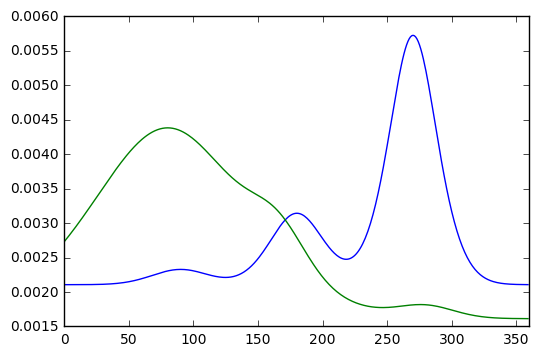

In [507]:
plt.plot(x,p_0)
plt.plot(x,p_1)
plt.xlim(0,360)
plt.show()

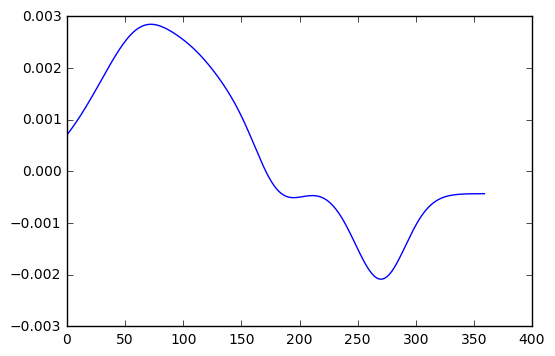

In [508]:
plt.plot(x,(p_1*np.log(p_1/p_0)))
plt.show()

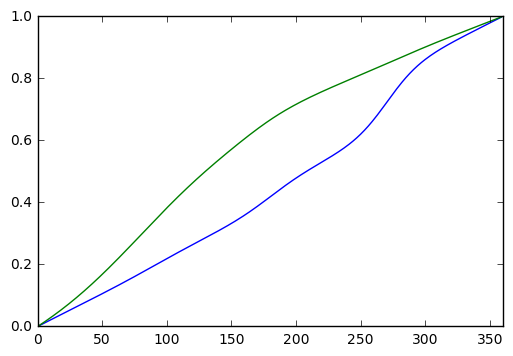

In [509]:
plt.plot(x,cp_0)
plt.plot(x,cp_1)
plt.xlim(0,360)
plt.show()

In [510]:
ref_set = []
t = 10000
n = 0
while n < 200:
    x = np.mgrid[0:360:1]
    x_0 = inv_cumulative(np.random.random(),x,cp_0)
    brownian_ref = brownian_dynamics_1d(V=V_0)
    brownian_ref.integrate_brownian(x_0, t, 1)
    ref_set.append(brownian_ref.X_t)
    n += 1

In [511]:
test_set = []
t = 10000
n = 0
while n < 200:
    x = np.mgrid[0:360:1]
    x_0 = inv_cumulative(np.random.random(),x,cp_1)
    brownian_test = brownian_dynamics_1d(V=V_1)
    brownian_test.integrate_brownian(x_0, t, 1)
    test_set.append(brownian_test.X_t)
    n += 1

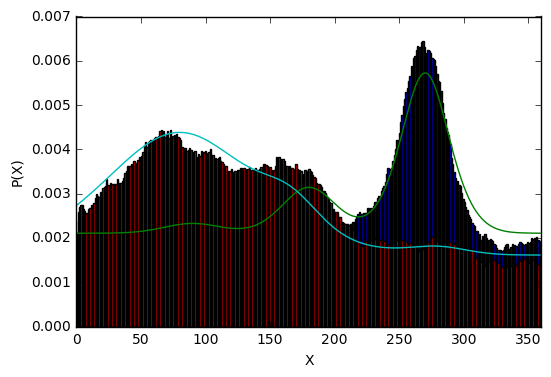

In [516]:
plt.hist(np.vstack(ref_set),range=[0,360],bins=359,normed=True)
brownian_ref.plot_probability()
plt.hist(np.vstack(test_set),range=[0,360],bins=359,normed=True)
brownian_test.plot_probability()
plt.show()

In [9]:
# KL_div tests with 1d Brownian dynamics

In [7]:
import kl_divergence as kl_div

In [517]:
kl = kl_div.local_kl_divergence()

In [518]:
kl.dih_ref = [['RES1',ref_set]]
kl.dih_test = [['RES1',test_set]]

In [519]:
kl_divergence, raw_kl = kl.kl_div(binrange=[0,360],return_raw=True)
raw_kl = raw_kl[0]

In [520]:
kl_divergence

[['RES1', 0.12775391865390026]]

In [521]:
kl_div_H0, bootstrap = kl.kl_div_H0(binrange=[0,360])
bootstrap = np.array(bootstrap[0])

In [522]:
kde = sp.stats.kde.gaussian_kde(bootstrap)

In [523]:
x = np.mgrid[0:max(bootstrap):max(bootstrap)/100.0]

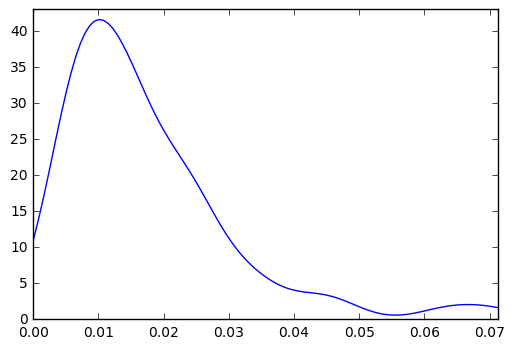

In [530]:
plt.plot(x,kde(x))
#plt.plot(x,cumulative(x))
#plt.scatter(raw_kl,kde.integrate_box(0,raw_kl))
#plt.plot(x,x.shape[0]*[.05])
plt.scatter(raw_kl,kde(raw_kl))
plt.ylim(0,round(kde(x).max())+1)
plt.xlim(0,x.max())
plt.show()

In [525]:
(bootstrap[bootstrap > raw_kl].sum())/float(bootstrap.sum())

0.0

In [526]:
gamma = .001
rprob = (np.histogram(np.vstack(ref_set),bins=20,range=[0,360])[0]+gamma)/float(np.sum(np.histogram(np.vstack(ref_set),bins=20,range=[0,360])[0]+gamma))
tprob = (np.histogram(np.vstack(test_set),bins=20,range=[0,360])[0]+gamma)/float(np.sum(np.histogram(np.vstack(ref_set),bins=20,range=[0,360])[0]+gamma))

In [527]:
np.sum(tprob*np.log(tprob / rprob))

0.14465752295432685

In [528]:
raw_kl

0.14409730610427726

In [529]:
kl_div_H0

[0.017540506490819459]

In [531]:
import multiprocessing

In [532]:
multiprocessing.cpu_count()

4